In [41]:
import os
import glob
import librosa
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import IPython.display as ipd

from scipy.io import wavfile
from librosa import display
from librosa.effects import split
from librosa.feature import rms, zero_crossing_rate, spectral_centroid, spectral_bandwidth, spectral_rolloff
from librosa.beat import tempo 
from sklearn.preprocessing import MinMaxScaler

In [42]:
root = 'raw_audio/'
audio_tracks = []

for filename in glob.glob(os.path.join(root, '*.wav')):
    samplerate, data = wavfile.read(filename)
    audio_tracks.append(data)

In [43]:
audio_paths = [root + f'music{n}.wav'.format(n) for n in range(len(audio_tracks))]

In [44]:
root = 'raw_audio/'
audio_tracks = []

for path in audio_paths:
    audio_tracks.append(librosa.load(path))

### Data Visualization

In [45]:
example_path = audio_paths[-1]
example_x, example_sr = audio_tracks[-1]

In [46]:
ipd.Audio(example_path)

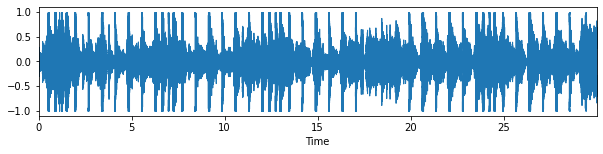

In [47]:
plt.figure(figsize=(10, 2))
display.waveplot(example_x, sr=example_sr)

In [48]:
spectrum = librosa.stft(example_x, n_fft=NFFT, hop_length=HOP_LENGTH)
S = librosa.amplitude_to_db(abs(spectrum)) 

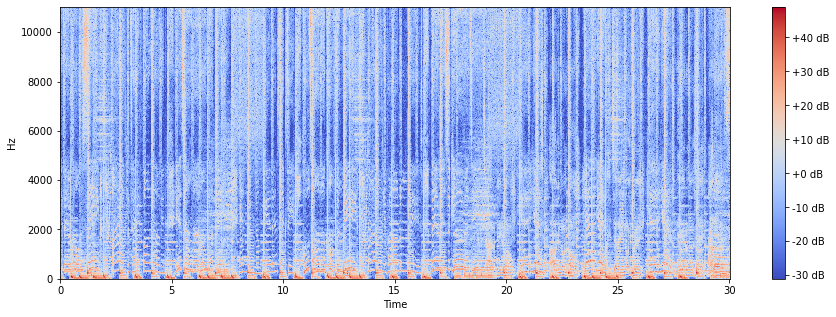

In [49]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(S, sr=example_sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')

### Feature extraction

In [50]:
FRAME_LENGTH = 1024 # Chunk size 
HOP_LENGTH = 512    # Number of samples between each frame
NFFT = 1024         # Fourier Transform window size 

In [51]:
features = {}

In [52]:
# For classificatiion tasks, we are looking for selective features, allowing discriminate the samples 
# into different categories

##### Time domain features

In [53]:
def zero_crossing(sig):
    return zero_crossing_rate(sig, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH, pad=False)

def RMS(sig):
    return rms(sig, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)

In [54]:
## Zero crossing Rate ##
features['zer_crossing_rate_mean'] = [np.mean(zero_crossing(x)) for x, _ in audio_tracks]
features['zero_crossing_rate_std'] = [np.std(zero_crossing(x)) for x, _ in audio_tracks]

In [55]:
## RMS ##
features['rms_mean'] =  [np.mean(rms(x)) for x, _ in audio_tracks]
features['rms_std'] = [np.std(rms(x)) for x, _ in audio_tracks]

##### Time-frequency domain features

In [56]:
## Spectral Centroids ##
features['spectral_centroid_mean'] = [np.mean(spectral_centroid(x, sr)) for x, sr in audio_tracks]
features['spectral_centroid_std'] = [np.std(spectral_centroid(x, sr)) for x, sr in audio_tracks]

In [57]:
## Spectral Rolloff ## 
features['spectral_rolloff_mean'] = [np.mean(spectral_rolloff(x, sr)) for x, sr in audio_tracks]
features['spectral_rolloff_std'] = [np.std(spectral_rolloff(x, sr)) for x, sr in audio_tracks]

In [58]:
def chroma_stft(sig, sr):
    return librosa.feature.chroma_stft(sig, sr, n_fft=NFFT, hop_length=HOP_LENGTH)

In [59]:
## Chroma STFT ## 
features['chroma_stft_mean'] = [np.mean(chroma_stft(x, sr)) for x, sr in audio_tracks]
features['chroma_stft_std'] = [np.std(chroma_stft(x, sr)) for x, sr in audio_tracks]

##### Global Features - Song Analysis

In [60]:
## Tempo ##
features['tempo'] = [tempo(x, sr) for x, sr in audio_tracks]

In [61]:
dfeatures = pd.DataFrame(features)
dfeatures.head()

,zer_crossing_rate_mean,zero_crossing_rate_std,rms_mean,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_rolloff_mean,spectral_rolloff_std,chroma_stft_mean,chroma_stft_std,tempo
0,0.051957,0.040343,0.077110,0.077108,1198.459085,402.342968,2477.275946,997.131085,0.392258,0.318590,[83.35433467741936]
1,0.092505,0.033391,0.136321,0.021771,2278.961252,413.395578,5198.594860,754.756161,0.477115,0.287227,[135.99917763157896]
2,0.111524,0.038869,0.243229,0.071317,2207.219165,429.253188,4658.382917,1044.335842,0.464678,0.289394,[99.38401442307692]
3,0.093250,0.032548,0.069147,0.035831,1551.198031,351.097718,2840.958923,661.943625,0.327212,0.288870,[117.45383522727273]
4,0.036038,0.007039,0.020146,0.013459,690.200858,88.945216,749.140636,121.186297,0.310418,0.312079,[99.38401442307692]


In [62]:
scaler = MinMaxScaler(feature_range=(-1, 1))
dfeatures_scaled = pd.DataFrame(scaler.fit_transform(dfeatures.values), columns=dfeatures.columns)

In [63]:
dfeatures_scaled.head()

,zer_crossing_rate_mean,zero_crossing_rate_std,rms_mean,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_rolloff_mean,spectral_rolloff_std,chroma_stft_mean,chroma_stft_std,tempo
0,-0.788160,-0.400781,-0.489302,-0.032354,-0.668897,-0.461353,-0.509149,-0.184772,-0.172192,0.410453,-1.000000
1,-0.336112,-0.525860,0.041539,-0.873641,0.034993,-0.442356,0.263801,-0.410346,0.686123,-0.545952,1.000000
2,-0.124086,-0.427308,1.000000,-0.120400,-0.011743,-0.415101,0.110362,-0.140839,0.560322,-0.479873,-0.391026
3,-0.327810,-0.541033,-0.560691,-0.659893,-0.439106,-0.549430,-0.405850,-0.496725,-0.830128,-0.495848,0.295455
4,-0.965638,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.211899,-0.391026
